In [2]:
import numpy as np
import sys
from itertools import combinations_with_replacement
from scipy import stats

# Jacks Car Rental - Figure 4.1

In [92]:
# This is copy paste from another solution to speed up poisson calculations
poisson_cache = {}
def poisson(k, k_max, lam):
    """Truncated Poisson distribution"""
    global poisson_cache
    if (k, k_max, lam) in poisson_cache:
        return poisson_cache[(k, k_max, lam)]

    if k < k_max:
        p = stats.poisson.pmf(k, lam)
    elif k == k_max:
        # basically it's mass of the right tail
        p = 1 - stats.poisson.cdf(k_max-1, lam)
    else:
        assert False, 'k > k_max'
    
    poisson_cache[(k, k_max, lam)] = p
    return p

In [93]:
class JacksCarRentalMDP:
    def __init__(self, 
                 rental_reward=10, 
                 move_cost=2, 
                 expected_req1=3, 
                 expected_req2=4,
                 expected_ret1=3,
                 expected_ret2=2,
                 max_parked=20,
                 max_move=5,
                 gamma=0.9,
                 theta=1.0):
        self.rental_reward = rental_reward # Reward for renting out a car
        self.move_cost = move_cost         # Cost of moving a car from one location to another
        self.expected_req1 = expected_req1 # Expected car rental requests at first location
        self.expected_req2 = expected_req2 # Expected car rental requests at second location
        self.expected_ret1 = expected_ret1 # Expected car returns at first location
        self.expected_ret2 = expected_ret2 # Expected car returns at second location
        self.max_parked = max_parked       # Maximum number of allowed parked cars at each location 
        self.max_move = max_move           # Maximum number of cars than can be moved from one location to another overnight
        self.gamma = gamma
        self.theta = theta
        
        # Initialize policy and state values
        # 0-max_parked cars at each location: max_parked x max_parked
        self.policy = np.zeros((self.max_parked + 1, self.max_parked + 1), dtype=int)
        self.values = np.zeros((self.max_parked + 1, self.max_parked + 1), dtype=float)
        
    def states(self):
        # Iterator over all states (max_parked x max_parked)
        # We could also just return a list of tuples instead. The generator is just to save memory.
        for n1 in range(self.max_parked + 1):
            for n2 in range(self.max_parked + 1):
                yield n1, n2
        
    def transitions(self, n_cars, req_expected, ret_expected):
        """
        Iterator over all possible transitions from a given number of cars for a given location
        Args:
            n_cars: Number of cars currently at the location
            req_expected: Expected number of car rental requests at the given location
            ret_expected: Expected number of car returns at the given location
        """
        p_total = 0.0
        
        # Requests can range from 0 to n_cars at a location
        for requests in range(n_cars + 1):
            # Calculate probability of "requests" car rental requests 
            p_requests = poisson(requests, n_cars, req_expected)
            # The maximal number of car returns is maximum number of cars that can be parked at the location -
            # (number of cars currently parked at the location - number of car rental requests)
            max_returns = self.max_parked - (n_cars - requests)
            
            # Returns can range from 0 to max_returns at a location.
            # We cannot receive more cars than we have leftover room for.
            for returns in range(max_returns + 1):
                # Calculate probability of "returns" car returns
                p_returns = poisson(returns, max_returns, ret_expected)
                
                # Add environment response outcome (requests, returns) along with their probabilities
                yield requests, p_requests, returns, p_returns
                
                # Book keeping: Confirm that the total probability over all request x response outcomes sums to 1
                p_total += p_requests * p_returns
        assert np.allclose(p_total, 1.0), 'Total probability must be 1.0'
    
    def actions(self, n1, n2):
        """
        Iterator over all actions in state.
        Positive actions represent moves from first location to second location
        Negative actions represent moves from second location to first location
        Args:
            n1: Number of cars currently at first location
            n2: Number of cars currently at second location
        """
        assert n1 <= self.max_parked
        assert n2 <= self.max_parked
        
        # Iterate over number of cars to move from first location to second location
        # We can move anything between 0 and the minimum of the number of cars currently present at the 
        # first location and max_move
        for a in range(min(n1, self.max_move) + 1):
            # We iterate until we end up moving more cars than there's free room for at the second location
            if (a + n2) > self.max_parked:
                break
            yield a
        
        # Iterate over number of cars to move from second location to first location
        # We have already covered the action of moving 0 cars, so we start from 1
        # We can move anything between 1 and the minimum of the number of cars currently present at the
        # second location and max_move
        for a in range(1, min(n2, self.max_move) + 1):
            # We iterate until we end up moving more cars than there's free room for at the first location
            if (a + n1) > self.max_parked:
                break
            yield -a
            
    def q_value(self, n1, n2, action):
        """
        Calculates the q_value for a given state (n1, n2)-pair and action
        """
        
        # Start out subtracting costs of moving the cars suggested by the action
        q = -self.move_cost * abs(action)
        
        # Number of cars left at each location following the action
        n1_after = n1 - action
        n2_after = n2 + action
        assert n1_after >= 0, 'n1_after >= 0'
        assert n2_after >= 0, 'n2_after >= 0'
        assert n1_after <= self.max_parked, 'n1_after <= self.max_parked'
        assert n2_after <= self.max_parked, 'n2_after <= self.max_parked'
        
        # Calculate the environments response following the action
        # Iterate over all request, response outcomes given the number of cars left at first location
        for req1, p_req1, ret1, p_ret1 in self.transitions(n1_after, self.expected_req1, self.expected_ret1):
            # Iterate over all request, response outcomes given the number of cars left at second location
            for req2, p_req2, ret2, p_ret2 in self.transitions(n2_after, self.expected_req2, self.expected_ret2):
                
                # Multiply all request and response probabilities to get the total probability for the transition
                p_next_state = p_req1 * p_ret1 * p_req2 * p_ret2
                
                # Total reward for the action is the total requests at both locations multiplied by the reward per car
                r = self.rental_reward * (req1 + req2)
                
                n1_next = n1_after - req1 + ret1
                n2_next = n2_after - req2 + ret2
                
                assert n1_next >= 0, 'n1_next >= 0'
                assert n2_next >= 0, 'n2_next >= 0'
                assert n1_next <= self.max_parked, 'n1_next <= self.max_parked'
                assert n2_next <= self.max_parked, 'n2_next <= self.max_parked'
                
                q += p_next_state * (r + self.values[n1_next, n2_next] * self.gamma)
        return q
    
    def policy_evaluation(self):
        while True:
            values_new = np.zeros_like(self.values)
            for n1, n2 in self.states():
                action = self.policy[n1, n2]
                q = self.q_value(n1, n2, action)
                values_new[n1, n2] = q
            
            delta = np.max(np.abs(values_new - self.values))
            self.values = values_new
            sys.stdout.write('.')
            if delta < self.theta:
                break
        sys.stdout.write('\n')
                
    def policy_improvement(self):
        policy_stable = True
        for n1, n2 in self.states():
            actions = list(self.actions(n1, n2))
            qs = list(map(lambda a: self.q_value(n1, n2, a), actions))
            a_max = actions[np.argmax(qs)]
            if self.policy[n1, n2] != a_max:
                policy_stable = False
                self.policy[n1, n2] = a_max
        return policy_stable
    
    def policy_iteration(self):
        it = 0
        policy_stable = False
        while not policy_stable:
            print("Policy Iteration {}".format(it))
            self.policy_evaluation()
            policy_stable = self.policy_improvement()
            it += 1
        print('Policy Iteration converged after {} iterations'.format(it))
        
            

In [94]:
mdp1 = JacksCarRentalMDP(max_parked=20)
mdp1.policy_iteration()

Policy Iteration 0
......................................
Policy Iteration 1
.........
Policy Iteration 2
.........
Policy Iteration 3
..
Policy Iteration 4
.
Policy Iteration 5
.
Policy Iteration converged after 6 iterations


In [95]:
import pickle
with open('jacks_car_rental_mdp.pkl', "wb") as f:
    pickle.dump(mdp1, f)

In [98]:
import matplotlib.pyplot as plt
def visualize(mdp):
    height = mdp.policy.shape[0]
    width = mdp.policy.shape[1]
    
    y_ticks = np.arange(height) + 0.5
    x_ticks = np.arange(width) + 0.5
    y_labels = np.arange(height + 1)
    x_labels = np.arange(width + 1)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))    
    ax = axs[0]
    pc = ax.pcolor(mdp.policy)
    fig.colorbar(pc, ax=ax)
    ax.set_yticks(y_ticks)
    ax.set_xticks(x_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xticklabels(x_labels)
    ax.set_title('policy')
    
    ax = axs[1]
    pc = ax.pcolor(mdp.values)
    fig.colorbar(pc, ax=ax)
    ax.set_yticks(y_ticks)
    ax.set_xticks(x_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xticklabels(x_labels)
    ax.set_title('values')
    
    plt.show()

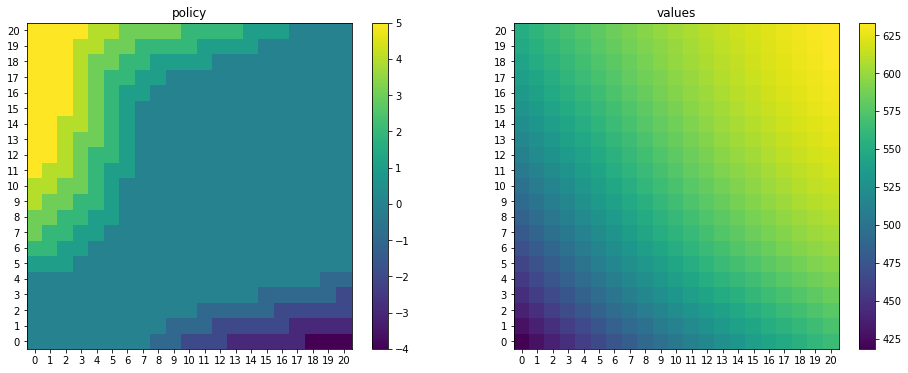

In [99]:
visualize(mdp1)

# Jacks Car Rental - Exercise 4.7

Changes to the original problem
* One of Jack's employees is able to move __one__ car from location 1 to location 2 each night for free
* If more than 10 cars are kept overnight at a location (after any moving of cars) then an additional cost of 4 dollars must be incurred to use extra parking space independent of the extra number of cars.

In [102]:
class JacksCarRentalModifiedMDP(JacksCarRentalMDP):
    def __init__(self, *args, free_1to2_moves=1, extra_parking_lot_threshold=10, extra_parking_lot_cost=4, **kwargs):
        super().__init__(*args, **kwargs)
        self.free_1to2_moves = free_1to2_moves
        self.extra_parking_lot_threshold = extra_parking_lot_threshold
        self.extra_parking_lot_cost = extra_parking_lot_cost
        
    def q_value(self, n1, n2, action):
        q = 0.0
        if action < 0:
            # If the action will move at least one car from location 1 to location 2, then use the free move
            q -= self.move_cost * (abs(action) - self.free_1to2_moves)
        else:
            q -= self.move_cost * abs(action)
            
        n1_after = n1 - action
        n2_after = n2 + action
        
        if n1_after > self.extra_parking_lot_threshold:
            # pay for extra parking lot
            q -= self.extra_parking_lot_cost
            
        if n2_after > self.extra_parking_lot_threshold:
            # pay for extra parking lot
            q -= self.extra_parking_lot_cost
            
        assert n1_after >= 0, 'n1_after >= 0'
        assert n2_after >= 0, 'n2_after >= 0'
        assert n1_after <= self.max_parked, 'n1_after <= self.max_parked'
        assert n2_after <= self.max_parked, 'n2_after <= self.max_parked'
        
        for req1, p_req1, ret1, p_ret1 in self.transitions(n1_after, self.expected_req1, self.expected_ret1):
            for req2, p_req2, ret2, p_ret2 in self.transitions(n2_after, self.expected_req2, self.expected_ret2):
                
                p_next_state = p_req1 * p_ret1 * p_req2 * p_ret2
                r = self.rental_reward * (req1 + req2)
                
                n1_next = n1_after - req1 + ret1
                n2_next = n2_after - req2 + ret2
                
                assert n1_next >= 0, 'n1_next >= 0'
                assert n2_next >= 0, 'n2_next >= 0'
                assert n1_next <= self.max_parked, 'n1_next <= self.max_parked'
                assert n2_next <= self.max_parked, 'n2_next <= self.max_parked'
                
                q += p_next_state * (r + self.values[n1_next, n2_next] * self.gamma)
        return q

In [104]:
mdp2 = JacksCarRentalModifiedMDP(max_parked=20)
mdp2.policy_iteration()

Policy Iteration 0
......................................
Policy Iteration 1
............
Policy Iteration 2
..........
Policy Iteration 3
..
Policy Iteration 4
.
Policy Iteration converged after 5 iterations


In [105]:
import pickle
with open('jacks_car_rental_mdp2.pkl', "wb") as f:
    pickle.dump(mdp2, f)

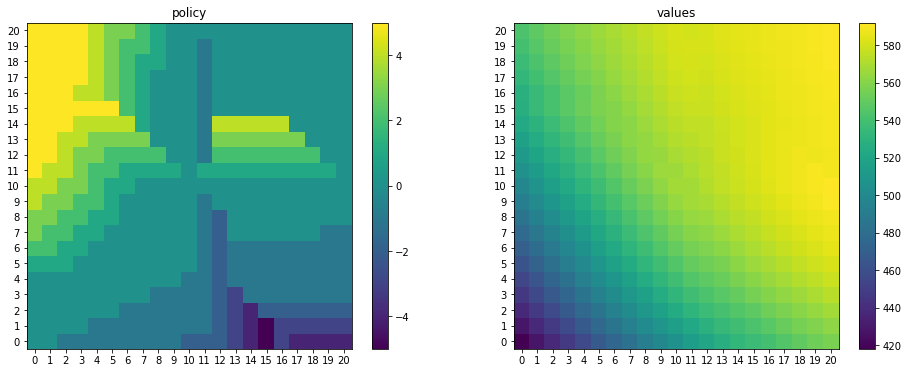

In [106]:
visualize(mdp2)